# Analyzing time series with Pandas

## Dataset
We will use a sample dataset for occupancy detection: http://archive.ics.uci.edu/ml/datasets/Occupancy+Detection+

First we download the dataset into the `./data` directory.

Note: more datasets can be found here: https://machinelearningmastery.com/time-series-datasets-for-machine-learning/

In [1]:
!pip -q install "dask[complete]" pyarrow 
!wget -q http://archive.ics.uci.edu/ml/machine-learning-databases/00357/occupancy_data.zip -O occupancy_data.zip
!unzip -qq -o occupancy_data.zip -d data
!ls -al ./data
!head ./data/datatraining.txt

     |████████████████████████████████| 48.5MB 1.4MB/s 
total 1476
drwxr-xr-x 2 root root   4096 May  8 08:38 .
drwxr-xr-x 1 root root   4096 May  8 08:38 ..
-rw-r--r-- 1 root root 699664 Jan  5  2016 datatest2.txt
-rw-r--r-- 1 root root 200766 Jan  5  2016 datatest.txt
-rw-r--r-- 1 root root 596674 Jan  5  2016 datatraining.txt
"date","Temperature","Humidity","Light","CO2","HumidityRatio","Occupancy"
"1","2015-02-04 17:51:00",23.18,27.272,426,721.25,0.00479298817650529,1
"2","2015-02-04 17:51:59",23.15,27.2675,429.5,714,0.00478344094931065,1
"3","2015-02-04 17:53:00",23.15,27.245,426,713.5,0.00477946352442199,1
"4","2015-02-04 17:54:00",23.15,27.2,426,708.25,0.00477150882608175,1
"5","2015-02-04 17:55:00",23.1,27.2,426,704.5,0.00475699293331518,1
"6","2015-02-04 17:55:59",23.1,27.2,419,701,0.00475699293331518,1
"7","2015-02-04 17:57:00",23.1,27.2,419,701.666666666667,0.00475699293331518,1
"8","2015-02-04 17:57:59",23.1,27.2,419,699,0.00475699293331518,1
"9","2015-02-04 17:58:59",23.1,

In [2]:
import pandas as pd
import dask
import dask.dataframe as dd
import numpy as np

# For more advanced date parsing use:
import datetime
dateparser = lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')  #https://docs.python.org/3/library/datetime.html#strftime-strptime-behavior
#df = pd.read_csv("./data/datatraining.txt", converters={'date':dateparser}); df.set_index('date',inplace=True,verify_integrity=True)

# You can specify the desired dtypes explicitly. Beware that e.g. np.uint8 may overflow during subsequent operations.
desired_dtypes={
       'Temperature':np.float32,
       'Humidity':np.float32,
       'Light':np.float32,
       'CO2':np.float32,
       'HumidityRatio':np.float32,
       'Occupancy':np.uint8
}

pdf = pd.read_csv("./data/datatraining.txt",dtype=desired_dtypes, converters={'date':pd.to_datetime}) # or dateparser to be more explicit
pdf.set_index('date',inplace=True,verify_integrity=True)

print(pdf.info())
pdf.head()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8143 entries, 2015-02-04 17:51:00 to 2015-02-10 09:33:00
Data columns (total 6 columns):
Temperature      8143 non-null float32
Humidity         8143 non-null float32
Light            8143 non-null float32
CO2              8143 non-null float32
HumidityRatio    8143 non-null float32
Occupancy        8143 non-null uint8
dtypes: float32(5), uint8(1)
memory usage: 230.6 KB
None


,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
date,,,,,,
2015-02-04 17:51:00,23.18,27.271999,426.0,721.25,0.004793,1
2015-02-04 17:51:59,23.15,27.267500,429.5,714.00,0.004783,1
2015-02-04 17:53:00,23.15,27.245001,426.0,713.50,0.004779,1
2015-02-04 17:54:00,23.15,27.200001,426.0,708.25,0.004772,1
2015-02-04 17:55:00,23.10,27.200001,426.0,704.50,0.004757,1


In [3]:
# Equivalent but using dask (for multiple files and scalability)
ddf = dd.read_csv('./data/*.txt',dtype=desired_dtypes,converters={'date':pd.to_datetime}).set_index('date')
ddf.index # make sure it is indeed a DatetimeIndex

Dask Index Structure:
npartitions=3
2015-02-02 14:19:00.000000000    datetime64[ns]
2015-02-06 20:44:14.750000128               ...
2015-02-12 23:18:12.000000000               ...
2015-02-18 09:19:00.000000000               ...
Name: date, dtype: datetime64[ns]
Dask Name: sort_index, 35 tasks

In [4]:
pdf = ddf.compute() # converting from dask to pandas data frame
print(pdf.info())
pdf.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 20560 entries, 2015-02-02 14:19:00 to 2015-02-18 09:19:00
Data columns (total 6 columns):
Temperature      20560 non-null float32
Humidity         20560 non-null float32
Light            20560 non-null float32
CO2              20560 non-null float32
HumidityRatio    20560 non-null float32
Occupancy        20560 non-null uint8
dtypes: float32(5), uint8(1)
memory usage: 582.3 KB
None


,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
date,,,,,,
2015-02-02 14:19:00,23.700001,26.271999,585.200012,749.200012,0.004764,1
2015-02-02 14:19:59,23.718000,26.290001,578.400024,760.400024,0.004773,1
2015-02-02 14:21:00,23.730000,26.230000,572.666687,769.666687,0.004765,1
2015-02-02 14:22:00,23.722500,26.125000,493.750000,774.750000,0.004744,1
2015-02-02 14:23:00,23.754000,26.200001,488.600006,779.000000,0.004767,1


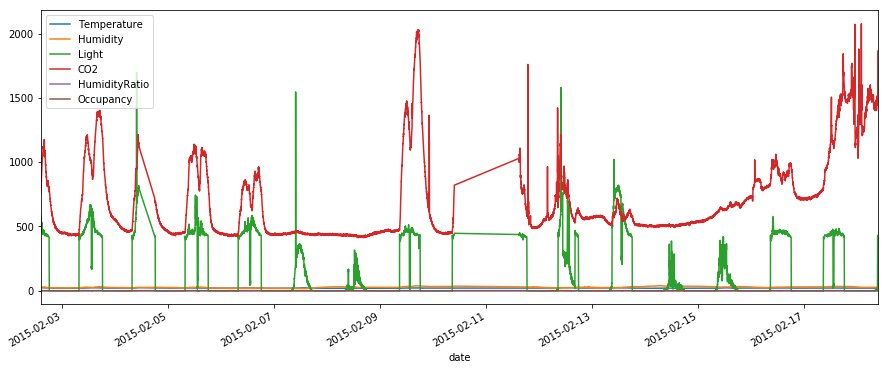

In [8]:
pdf.plot(figsize=(15, 6))

Because of the different scale of the quantities, we can't inspect them visually. Quick and dirty trick is to use a log plot.

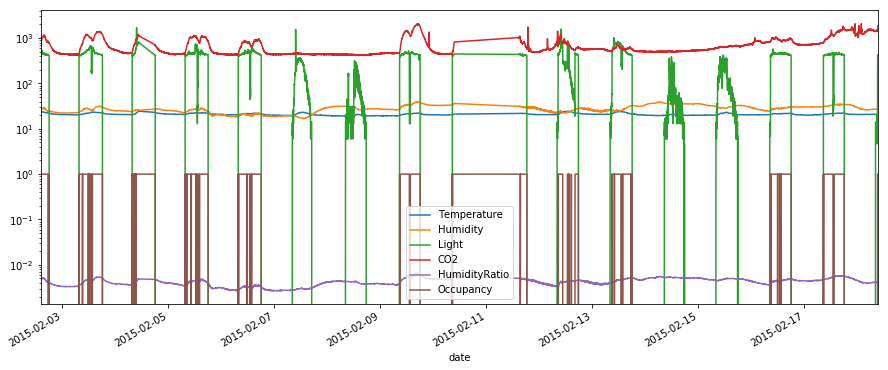

In [9]:
pdf.plot(figsize=(15, 6),logy=True)

Or we can scale the quantities

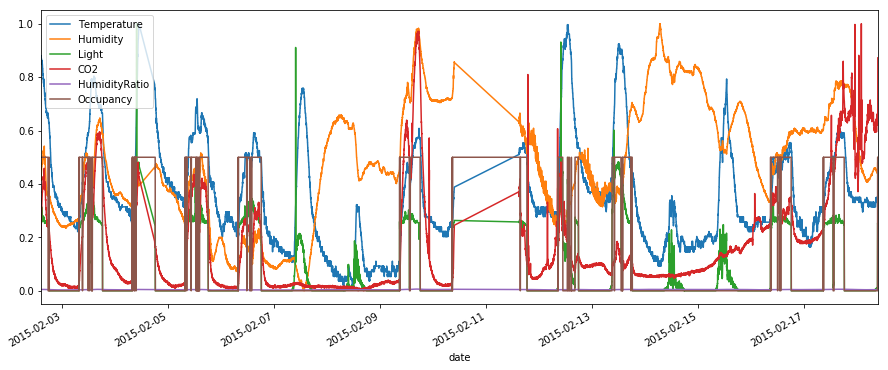

In [10]:
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()

columns_to_normalize = ['CO2','Light','Humidity','Temperature']
for c in columns_to_normalize:
  x = pdf[[c]].values.astype(float)
  scaled = mms.fit_transform(x)
  pdf[c] = scaled

pdf['Occupancy'] *= 0.5
pdf.plot(figsize=(15, 6))

Looks like too much info? You can plot individual columns as well.

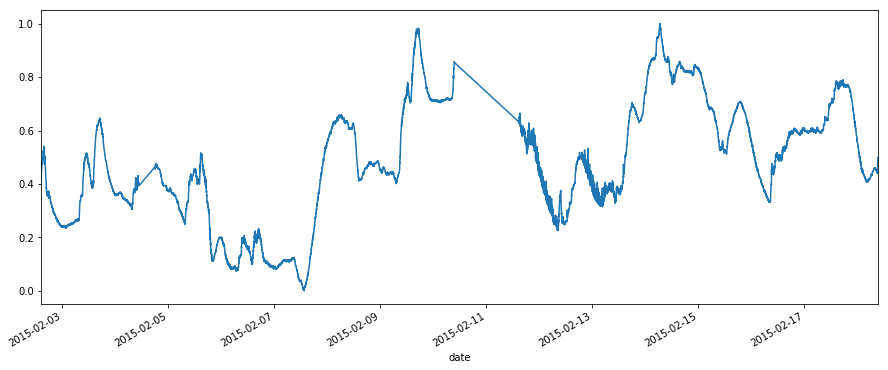

In [11]:
pdf['Humidity'].plot(figsize=(15, 6))

In [12]:
# Aggregates
pdf.groupby('Occupancy').mean() 

,Temperature,Humidity,Light,CO2,HumidityRatio
Occupancy,,,,,
0.0,0.293035,0.473947,0.01487,0.115550,0.004120
0.5,0.550245,0.497966,0.28397,0.338135,0.004589


In [13]:
# Can be done in dask too, e.g. for big datasets
ddf.groupby('Occupancy').mean().compute()

,Temperature,Humidity,Light,CO2,HumidityRatio
Occupancy,,,,,
0,20.584830,27.529653,25.237893,604.996584,0.004120
1,21.975908,28.076211,481.967368,975.321895,0.004589


Parquet format is more space efficient than CSV and allows for faster projections and index searches

In [14]:
ddf.to_parquet('data/2000-01.parquet', engine='pyarrow') # save dask dataframe as parquet

!ls -al data
!du -h data/2000-01.parquet

total 1480
drwxr-xr-x 3 root root   4096 May  7 06:07 .
drwxr-xr-x 1 root root   4096 May  7 05:59 ..
drwxr-xr-x 2 root root   4096 May  7 06:07 2000-01.parquet
-rw-r--r-- 1 root root 699664 Jan  5  2016 datatest2.txt
-rw-r--r-- 1 root root 200766 Jan  5  2016 datatest.txt
-rw-r--r-- 1 root root 596674 Jan  5  2016 datatraining.txt
388K	data/2000-01.parquet


In [0]:
# http://docs.dask.org/en/latest/use-cases.html
#df = dd.read_parquet('data/2000-01.parquet', engine='pyarrow')

I/O tips:

https://colab.research.google.com/notebooks/io.ipynb

In [15]:
# resample to 1 hour
ddf.resample('1h').mean().head()


,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
date,,,,,,
2015-02-02 14:00:00,23.657118,27.023720,499.978119,898.784851,0.004889,1.000000
2015-02-02 15:00:00,23.293951,28.412430,456.719055,1103.186279,0.005030,1.000000
2015-02-02 16:00:00,22.773142,26.737452,434.838989,979.565979,0.004585,1.000000
2015-02-02 17:00:00,22.534519,24.972128,426.736145,822.562866,0.004217,0.610169
2015-02-02 18:00:00,21.993372,24.595966,32.984165,720.400269,0.004018,0.083333


In [17]:
# Daily aggregates
ddf.resample('24h').mean().head(npartitions=3) # Dask head will span only the first partition by default

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
date,,,,,,
2015-02-02,21.825354,24.579990,174.843216,695.649475,0.004001,0.349398
2015-02-03,21.438301,25.889320,211.852570,783.349792,0.004119,0.415972
2015-02-04,21.323767,25.422657,113.565483,571.179749,0.003997,0.183613
2015-02-05,21.469044,24.189299,196.227936,685.939514,0.003841,0.374306
2015-02-06,20.880501,19.838108,199.104202,597.644043,0.003029,0.406944


In [18]:
# Rolling windows
ddf[['Light','CO2']].resample('1h').mean().rolling(window='10h').mean().head() #http://docs.dask.org/en/latest/dataframe-api.html#dask.dataframe.DataFrame.rolling

,Light,CO2
date,,
2015-02-02 14:00:00,499.978119,898.784851
2015-02-02 15:00:00,478.348587,1000.985565
2015-02-02 16:00:00,463.845388,993.845703
2015-02-02 17:00:00,454.568077,951.024994
2015-02-02 18:00:00,370.251295,904.900049


In [19]:
# Effective index location access
ddf.loc['2015-02-18'].head()

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
date,,,,,,
2015-02-18 00:00:00,20.889999,29.445000,0.0,1201.500000,0.004498,0
2015-02-18 00:01:00,20.889999,29.500000,0.0,1201.500000,0.004507,0
2015-02-18 00:02:00,20.889999,29.500000,0.0,1205.000000,0.004507,0
2015-02-18 00:03:00,20.889999,29.463333,0.0,1212.666626,0.004501,0
2015-02-18 00:04:00,20.889999,29.500000,0.0,1213.500000,0.004507,0


See: https://examples.dask.org/dataframe.html

## Working with time zones

In [0]:
dti = pd.date_range('2018-01-01', periods=300, freq='H')
dti.tz_localize('EET')

DatetimeIndex(['2018-01-01 00:00:00+02:00', '2018-01-01 01:00:00+02:00',
               '2018-01-01 02:00:00+02:00', '2018-01-01 03:00:00+02:00',
               '2018-01-01 04:00:00+02:00', '2018-01-01 05:00:00+02:00',
               '2018-01-01 06:00:00+02:00', '2018-01-01 07:00:00+02:00',
               '2018-01-01 08:00:00+02:00', '2018-01-01 09:00:00+02:00',
               ...
               '2018-01-13 02:00:00+02:00', '2018-01-13 03:00:00+02:00',
               '2018-01-13 04:00:00+02:00', '2018-01-13 05:00:00+02:00',
               '2018-01-13 06:00:00+02:00', '2018-01-13 07:00:00+02:00',
               '2018-01-13 08:00:00+02:00', '2018-01-13 09:00:00+02:00',
               '2018-01-13 10:00:00+02:00', '2018-01-13 11:00:00+02:00'],
              dtype='datetime64[ns, EET]', length=300, freq='H')

In [0]:
dti.tz_localize('EET').tz_convert('US/Pacific')

DatetimeIndex(['2017-12-31 14:00:00-08:00', '2017-12-31 15:00:00-08:00',
               '2017-12-31 16:00:00-08:00', '2017-12-31 17:00:00-08:00',
               '2017-12-31 18:00:00-08:00', '2017-12-31 19:00:00-08:00',
               '2017-12-31 20:00:00-08:00', '2017-12-31 21:00:00-08:00',
               '2017-12-31 22:00:00-08:00', '2017-12-31 23:00:00-08:00',
               ...
               '2018-01-12 16:00:00-08:00', '2018-01-12 17:00:00-08:00',
               '2018-01-12 18:00:00-08:00', '2018-01-12 19:00:00-08:00',
               '2018-01-12 20:00:00-08:00', '2018-01-12 21:00:00-08:00',
               '2018-01-12 22:00:00-08:00', '2018-01-12 23:00:00-08:00',
               '2018-01-13 00:00:00-08:00', '2018-01-13 01:00:00-08:00'],
              dtype='datetime64[ns, US/Pacific]', length=300, freq='H')

In [0]:
dti[0].day_name()

'Monday'

In [0]:
(dti[0] + pd.Timedelta('1 day')).day_name()

'Tuesday'

In [0]:
(dti[0] - pd.offsets.BDay()).day_name()

'Friday'

DateTime indices can be used to look up a range of dates 

In [23]:
ddf.loc['2015-02-02 14:25'].head() # partial match

/usr/local/lib/python3.6/dist-packages/dask/dataframe/core.py:4553: UserWarning: Insufficient elements for `head`. 5 elements requested, only 2 elements available. Try passing larger `npartitions` to `head`.
  warnings.warn(msg.format(n, len(r)))


,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
date,,,,,,
2015-02-02 14:25:00,23.730,26.290001,536.333313,798.0,0.004776,1
2015-02-02 14:25:59,23.754,26.290001,509.000000,797.0,0.004783,1


Range indexing is also possible. All seconds of the given minute will be included.

https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#partial-string-indexing 

In [35]:
pdf['2015-02-02 14:20':'2015-02-02 14:25']

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
date,,,,,,
2015-02-02 14:21:00,0.874576,0.416831,0.337409,0.214525,0.004765,0.5
2015-02-02 14:22:00,0.873190,0.412217,0.290912,0.217581,0.004744,0.5
2015-02-02 14:23:00,0.879014,0.415513,0.287877,0.220135,0.004767,0.5
2015-02-02 14:23:59,0.880123,0.418150,0.335052,0.226747,0.004779,0.5
2015-02-02 14:25:00,0.874576,0.419468,0.316001,0.231555,0.004776,0.5
2015-02-02 14:25:59,0.879014,0.419468,0.299897,0.230954,0.004783,0.5


Same can be achieved with custom indexing
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html

In [39]:
pdf[(pdf.index >= '2015-02-02 14:20') & (pdf.index <= '2015-02-02 14:25:59') ]

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
date,,,,,,
2015-02-02 14:21:00,0.874576,0.416831,0.337409,0.214525,0.004765,0.5
2015-02-02 14:22:00,0.873190,0.412217,0.290912,0.217581,0.004744,0.5
2015-02-02 14:23:00,0.879014,0.415513,0.287877,0.220135,0.004767,0.5
2015-02-02 14:23:59,0.880123,0.418150,0.335052,0.226747,0.004779,0.5
2015-02-02 14:25:00,0.874576,0.419468,0.316001,0.231555,0.004776,0.5
2015-02-02 14:25:59,0.879014,0.419468,0.299897,0.230954,0.004783,0.5


In [32]:
pdf[pdf.index.weekday.map(lambda x: x in [0,2])] # Mon and Wed only

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
date,,,,,,
2015-02-02 14:19:00,0.869029,0.418677,0.344793,0.202224,0.004764,0.5
2015-02-02 14:19:59,0.872358,0.419468,0.340787,0.208956,0.004773,0.5
2015-02-02 14:21:00,0.874576,0.416831,0.337409,0.214525,0.004765,0.5
2015-02-02 14:22:00,0.873190,0.412217,0.290912,0.217581,0.004744,0.5
2015-02-02 14:23:00,0.879014,0.415513,0.287877,0.220135,0.004767,0.5
2015-02-02 14:23:59,0.880123,0.418150,0.335052,0.226747,0.004779,0.5
2015-02-02 14:25:00,0.874576,0.419468,0.316001,0.231555,0.004776,0.5
2015-02-02 14:25:59,0.879014,0.419468,0.299897,0.230954,0.004783,0.5
2015-02-02 14:26:59,0.879014,0.422105,0.280454,0.234681,0.004794,0.5


You can also do fancy conversions using a pd.Series

In [0]:

days = ['Mon','Tue','Wed','Thu','Fri','Sat','sun']
#pd.Series(pdf.index.weekday,pdf.index).map(pd.Series(days))
pd.Series(pdf.index.weekday,pdf.index).map(lambda x: days[x] + '-'+ str(x))

date
2015-02-02 14:19:00    Mon-0
2015-02-02 14:19:59    Mon-0
2015-02-02 14:21:00    Mon-0
2015-02-02 14:22:00    Mon-0
2015-02-02 14:23:00    Mon-0
2015-02-02 14:23:59    Mon-0
2015-02-02 14:25:00    Mon-0
2015-02-02 14:25:59    Mon-0
2015-02-02 14:26:59    Mon-0
2015-02-02 14:28:00    Mon-0
2015-02-02 14:29:00    Mon-0
2015-02-02 14:30:00    Mon-0
2015-02-02 14:31:00    Mon-0
2015-02-02 14:31:59    Mon-0
2015-02-02 14:32:59    Mon-0
2015-02-02 14:34:00    Mon-0
2015-02-02 14:35:00    Mon-0
2015-02-02 14:36:00    Mon-0
2015-02-02 14:37:00    Mon-0
2015-02-02 14:38:00    Mon-0
2015-02-02 14:38:59    Mon-0
2015-02-02 14:39:59    Mon-0
2015-02-02 14:41:00    Mon-0
2015-02-02 14:42:00    Mon-0
2015-02-02 14:43:00    Mon-0
2015-02-02 14:44:00    Mon-0
2015-02-02 14:44:59    Mon-0
2015-02-02 14:45:59    Mon-0
2015-02-02 14:47:00    Mon-0
2015-02-02 14:48:00    Mon-0
                       ...  
2015-02-18 08:50:00    Wed-2
2015-02-18 08:51:00    Wed-2
2015-02-18 08:51:59    Wed-2
2015-02-1

See the pandas timeseries guide for more details: https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html

In [0]:
# See this for rolling windows: https://pandas.pydata.org/pandas-docs/stable/user_guide/computation.html#stats-aggregate
# https://github.com/pandas-dev/pandas/issues/15354